In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from shapely.geometry import LineString, Polygon, Point
from collections import Counter
import osmnx

In [2]:
#recuperation des données

ds = xr.open_dataset("c:/Users/paoliniart/Documents/EFAS_historical_2002_Isere.nc") #fond de carte EFAS
gdf = gpd.read_file("pipes.geojson")  

Text(0.5, 1.0, 'pipeline - Isère et Savoie')

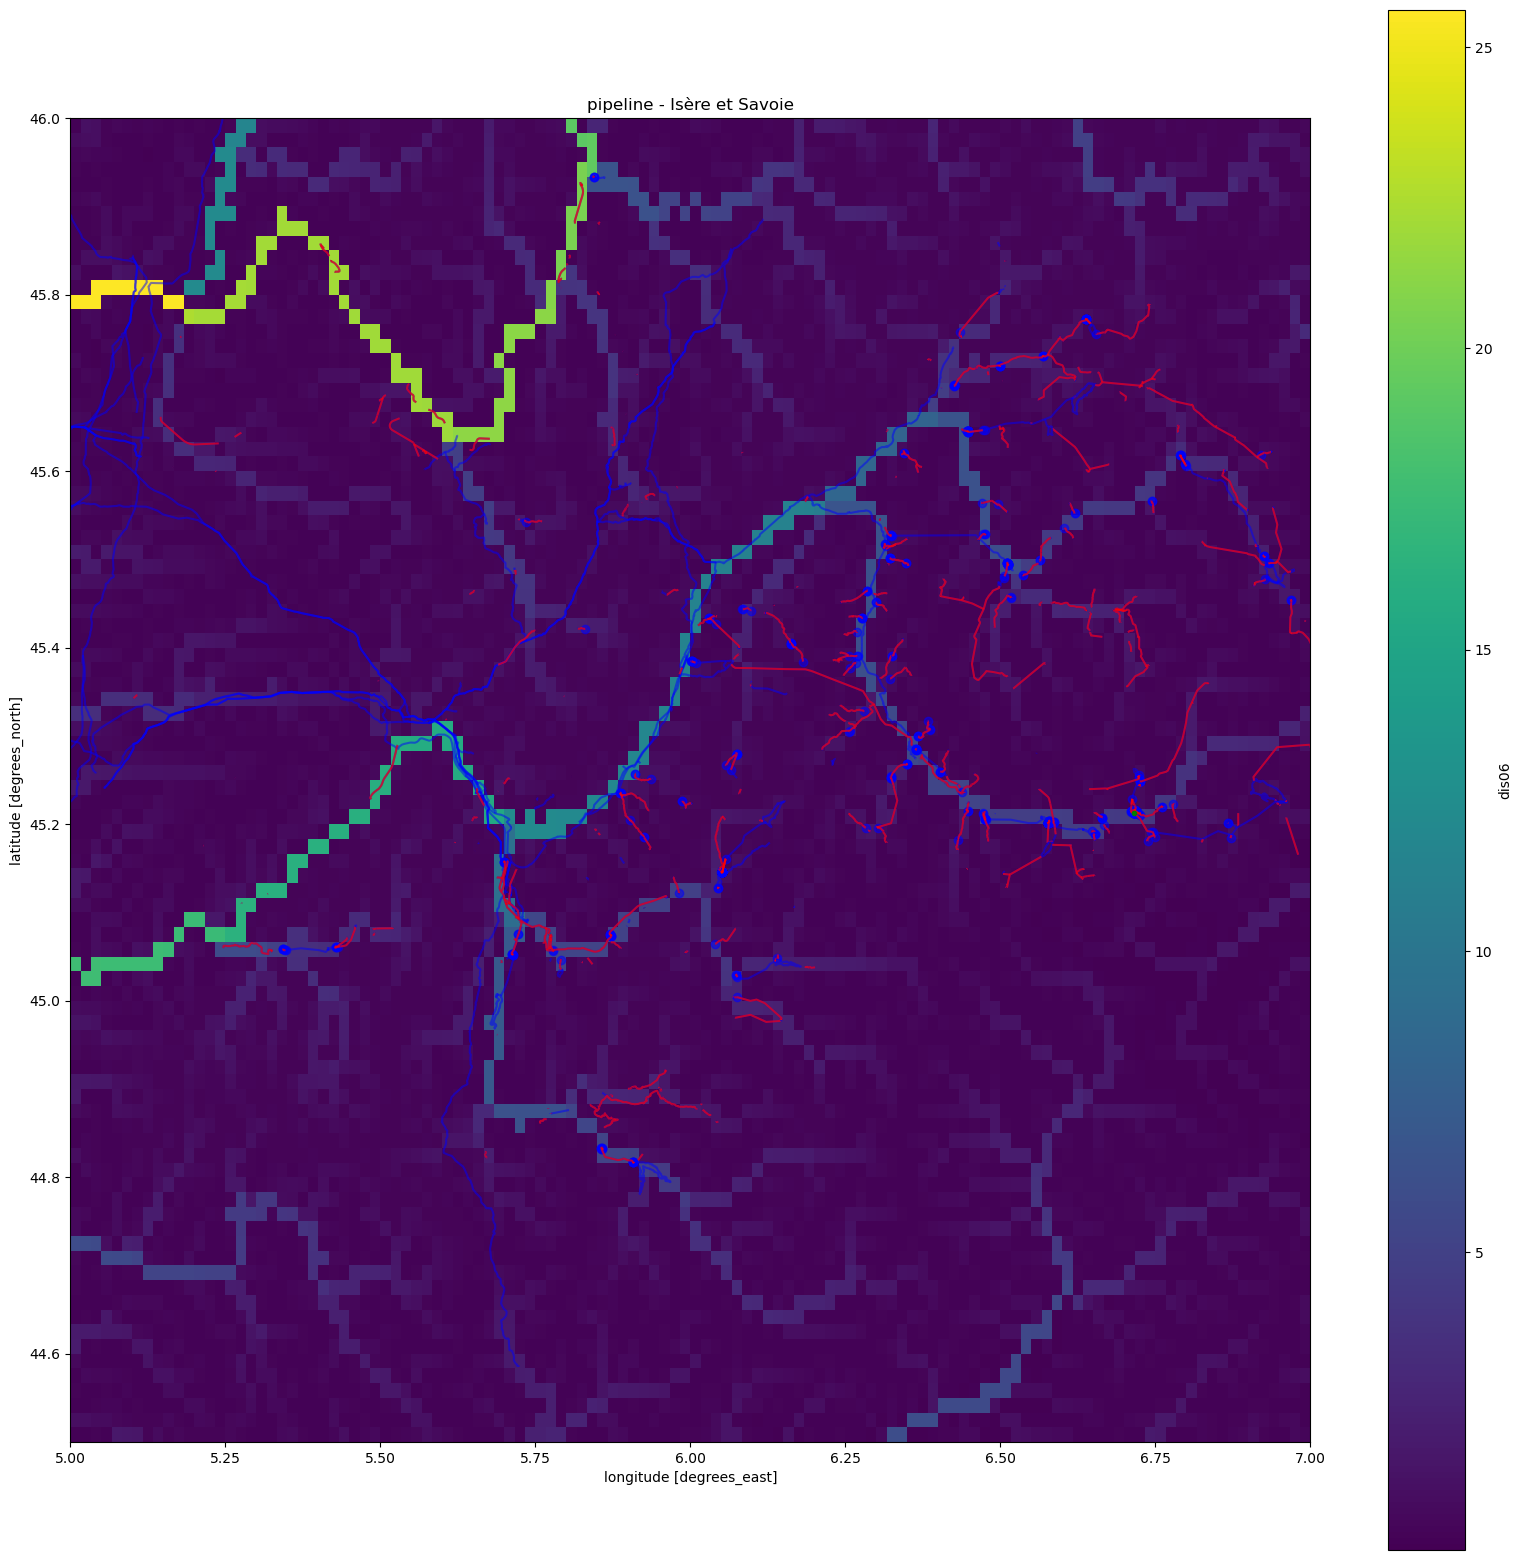

In [3]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20))
(ds.mean(dim = "valid_time").dis06**0.5).plot(ax = ax)
gdf.plot(ax=ax, color='blue', alpha=0.5)
gdf[gdf["waterway"].notna()].plot(ax=ax, color='red', alpha=0.7)
ax.plot([6.716161], [45.2128228], 'g.')
ax.set_ylim(44.5, 46)
plt.title("pipeline - Isère et Savoie")



In [4]:
water = gdf[gdf["waterway"].notna()]
efas_dem = xr.open_dataset("c:/Users/paoliniart/Documents/elv_European_01min.nc") #dem utilisé pour les tuyaux

In [5]:
pipes = water[water.geometry.type == "LineString"]

In [14]:
edges = []
nodes_set = set()

for idx, row in pipes.iterrows():
    coords = list(row.geometry.coords)
    for i in range(len(coords)-1):
        u = coords[i]
        v = coords[i+1]
        edges.append({"u": u, "v": v, "key": 0, "geometry": LineString([u,v])})
        nodes_set.add(u)
        nodes_set.add(v)

edges_gdf = gpd.GeoDataFrame(edges)

nodes_gdf = gpd.GeoDataFrame([
    {"x": n[0], "y": n[1], "geometry": Point(n)}
    for n in nodes_set
])

In [16]:
edges_gdf = gpd.GeoDataFrame(edges)
edges_gdf['u'] = edges_gdf['u'].apply(tuple)
edges_gdf['v'] = edges_gdf['v'].apply(tuple)
edges_gdf = edges_gdf.set_index(['u', 'v', 'key'])


nodes_gdf['node'] = nodes_gdf.apply(lambda r: (r['x'], r['y']), axis=1)
nodes_gdf = nodes_gdf.set_index('node')

In [17]:
pipes = osmnx.graph_from_gdfs(nodes_gdf, edges_gdf)

In [19]:
simplifiedGraph = osmnx.simplify_graph(pipes)

In [37]:
coord

array([[ 6.9364095, 45.6216639],
       [ 6.9189982, 45.6182671]])

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (150, 150))
(ds.mean(dim = "valid_time").dis06**0.5).plot(ax = ax)
gdf[gdf["waterway"].notna()].plot(ax=ax, color='red', alpha=0.3)

for l in list(simplifiedGraph.edges) :
    coord = np.array(l[:-1])
    alt_start = efas_dem.sel(lat = coord[0, 1], lon = coord[0, 0], method = "nearest").Band1.values
    alt_end = efas_dem.sel(lat = coord[1, 1], lon = coord[1, 0], method = "nearest").Band1.values
    if alt_start >= alt_end :
        ax.arrow(coord[0, 0], coord[0, 1], coord[1, 0] - coord[0, 0], coord[1, 1] - coord[0, 1], color = 'green')
    else : 
        ax.arrow(coord[0, 0], coord[0, 1], coord[1, 0] - coord[0, 0], coord[1, 1] - coord[0, 1], color = 'yellow')
